# 新手入门第四课——PaddlePaddle快速入门
![](https://ai-studio-static-online.cdn.bcebos.com/466b717826ff438a917074f4e62ca844e5f291ca1f8b48d7b78838d513ad7536)

终于进入到新手入门第四课啦~在最后一门课中我会给大家讲解如何快速入门PaddlePaddle，并让大家跑通一个小demo来熟悉PaddlePaddle的基本命令。

# PaddlePaddle基础命令
PaddlePaddle是百度开源的深度学习框架，类似的深度学习框架还有谷歌的Tensorflow、Facebook的Pytorch等，在入门深度学习时，学会并使用一门常见的框架，可以让学习效率大大提升。在PaddlePaddle中，计算的对象是张量，我们可以先使用PaddlePaddle来计算一个[[1, 1], [1, 1]] * [[1, 1], [1, 1]]。

## 计算常量的加法：1+1
首先导入PaddlePaddle库


In [ ]:
import paddle.fluid as fluid

定义两个张量的常量x1和x2，并指定它们的形状是[2, 2]，并赋值为1铺满整个张量，类型为int64.

In [ ]:
# 定义两个张量
x1 = fluid.layers.fill_constant(shape=[2, 2], value=1, dtype='int64')
x2 = fluid.layers.fill_constant(shape=[2, 2], value=1, dtype='int64')

接着定义一个操作，该计算是将上面两个张量进行加法计算，并返回一个求和的算子。PaddlePaddle提供了大量的操作，比如加减乘除、三角函数等，读者可以在fluid.layers找到。

In [ ]:
# 将两个张量求和
y1 = fluid.layers.sum(x=[x1, x2])

然后创建一个解释器，可以在这里指定计算使用CPU或GPU。当使用CPUPlace()时使用的是CPU，如果是CUDAPlace()使用的是GPU。解析器是之后使用它来进行计算过的，比如在执行计算之前我们要先执行参数初始化的program也是要使用到解析器的，因为只有解析器才能执行program。

In [ ]:
# 创建一个使用CPU的解释器
place = fluid.CPUPlace()
exe = fluid.executor.Executor(place)
# 进行参数初始化
exe.run(fluid.default_startup_program())

[]

最后执行计算，program的参数值是主程序，不是上一步使用的是初始化参数的程序，program默认一共有两个，分别是default_startup_program()和default_main_program()。fetch_list参数的值是在解析器在run之后要输出的值，我们要输出计算加法之后输出结果值。最后计算得到的也是一个张量。

In [ ]:
# 进行运算，并把y的结果输出
result = exe.run(program=fluid.default_main_program(),
                 fetch_list=[y1])
print(result)

[array([[2, 2],
       [2, 2]])]


## 计算变量的加法：1+1

上面计算的是张量常量的1+1，并不能随意修改常量的值，所以下面我们要编写一个使用张量变量作为乘数的程序，类似是一个占位符，等到将要计算时，再把要计算的值添加到占位符中进行计算。

导入PaddlePaddle库和numpy的库。

In [ ]:
import paddle.fluid as fluid
import numpy as np

定义两个张量，并不指定该张量的形状和值，它们是之后动态赋值的。这里只是指定它们的类型和名字，这个名字是我们之后赋值的关键。

In [ ]:
# 定义两个张量
a = fluid.layers.create_tensor(dtype='int64', name='a')
b = fluid.layers.create_tensor(dtype='int64', name='b')

使用同样的方式，定义这个两个张量的加法操作。

In [ ]:
# 将两个张量求和
y = fluid.layers.sum(x=[a, b])

这里我们同样是创建一个使用CPU的解析器，和进行参数初始化。

In [ ]:
# 创建一个使用CPU的解释器
place = fluid.CPUPlace()
exe = fluid.executor.Executor(place)
# 进行参数初始化
exe.run(fluid.default_startup_program())

[]

然后使用numpy创建两个张量值，之后我们要计算的就是这两个值。

In [ ]:
# 定义两个要计算的变量
a1 = np.array([3, 2]).astype('int64')
b1 = np.array([1, 1]).astype('int64')

这次exe.run()的参数有点不一样了，多了一个feed参数，这个就是要对张量变量进行赋值的。赋值的方式是使用了键值对的格式，key是定义张量变量是指定的名称，value就是要传递的值。在fetch_list参数中，笔者希望把a, b, y的值都输出来，所以要使用3个变量来接受返回值。

In [ ]:
# 进行运算，并把y的结果输出
out_a, out_b, result = exe.run(program=fluid.default_main_program(),
                               feed={'a': a1, 'b': b1},
                               fetch_list=[a, b, y])
print(out_a, " + ", out_b," = ", result)

(array([3, 2]), ' + ', array([1, 1]), ' = ', array([4, 3]))


# 使用PaddlePaddle做线性回归

在上面的教学中，教大家学会用PaddlePaddle做基本的算子运算，下面来教大家如何用PaddlePaddle来做简单的线性回归，包括从定义网络到使用自定义的数据进行训练，最后验证我们网络的预测能力。

首先导入PaddlePaddle库和一些工具类库。

In [ ]:
import paddle.fluid as fluid
import paddle
import numpy as np

定义一个简单的线性网络，这个网络非常简单，结构是：`输出层-->>隐层-->>输出层__`，这个网络一共有2层，因为输入层不算网络的层数。更具体的就是一个大小为100，激活函数是ReLU的全连接层和一个输出大小为1的全连接层，就这样构建了一个非常简单的网络。这里使用输入fluid.layers.data()定义的输入层类似`fluid.layers.create_tensor()`，也是有`name`属性，之后也是根据这个属性来填充数据的。这里定义输入层的形状为13，这是因为波士顿房价数据集的每条数据有13个属性，我们之后自定义的数据集也是为了符合这一个维度。

In [ ]:
# 定义一个简单的线性网络
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
hidden = fluid.layers.fc(input=x, size=100, act='relu')
net = fluid.layers.fc(input=hidden, size=1, act=None)

接着定义神经网络的损失函数，这里同样使用了`fluid.layers.data()`这个接口，这个可以理解为数据对应的结果，上面`name`为x的`fluid.layers.data()`为属性数据。这里使用了平方差损失函数`(square_error_cost)`，PaddlePaddle提供了很多的损失函数的接口，比如交叉熵损失函数`(cross_entropy)`。因为本项目是一个线性回归任务，所以我们使用的是平方差损失函数。因为`fluid.layers.square_error_cost()`求的是一个Batch的损失值，所以我们还要对他求一个平均值。

In [ ]:
# 定义损失函数
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
cost = fluid.layers.square_error_cost(input=net, label=y)
avg_cost = fluid.layers.mean(cost)

定义损失函数之后，可以在主程序`（fluid.default_main_program）`中克隆一个程序作为预测程序，用于训练完成之后使用这个预测程序进行预测数据。这个定义的顺序不能错，因为我们定义的网络结构，损失函数等等都是更加顺序记录到PaddlePaddle的主程序中的。主程序定义了神经网络模型，前向反向计算，以及优化算法对网络中可学习参数的更新，是我们整个程序的核心，这个是PaddlePaddle已经帮我们实现的了，我们只需注重网络的构建和训练即可。

In [ ]:
# 复制一个主程序，方便之后使用
test_program = fluid.default_main_program().clone(for_test=True)

接着是定义训练使用的优化方法，这里使用的是随机梯度下降优化方法。PaddlePaddle提供了大量的优化函数接口，除了本项目使用的随机梯度下降法（SGD），还有Momentum、Adagrad、Adagrad等等，读者可以更加自己项目的需求使用不同的优化方法。

In [ ]:
# 定义优化方法
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01)
opts = optimizer.minimize(avg_cost)

然后是创建一个解析器，我们同样是使用CPU来进行训练。创建解析器之后，使用解析器来执行fluid.default_startup_program()初始化参数。

In [ ]:
# 创建一个使用CPU的解释器
place = fluid.CPUPlace()
exe = fluid.Executor(place)
# 进行参数初始化
exe.run(fluid.default_startup_program())

[]

我们使用numpy定义一组数据，这组数据的每一条数据有13个，这是因为我们在定义网络的输入层时，shape是13，但是每条数据的后面12个数据是没意义的，因为笔者全部都是使用0来填充，纯粹是为了符合数据的格式而已。这组数据是符合y = 2 * x + 1，但是程序是不知道的，我们之后使用这组数据进行训练，看看强大的神经网络是否能够训练出一个拟合这个函数的模型。最后定义了一个预测数据，是在训练完成，使用这个数据作为x输入，看是否能够预测于正确值相近结果。

In [ ]:
# 定义训练和测试数据
x_data = np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                   [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                   [3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                   [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
                   [5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).astype('float32')
y_data = np.array([[3.0], [5.0], [7.0], [9.0], [11.0]]).astype('float32')
test_data = np.array([[6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).astype('float32')

定义数据之后，我们就可以使用数据进行训练了。我们这次训练了10个pass，读者可根据情况设置更多的训练轮数，通常来说训练的次数越多，模型收敛的越好。同样我们使用的时profram是fluid.default_main_program()，feed中是在训练时把数据传入fluid.layers.data()定义的变量中，及那个键值对的key对用的就是fluid.layers.data()中的name的值。我们让训练过程中输出avg_cost的值。

在训练过程中，我们可以看到输出的损失值在不断减小，证明我们的模型在不断收敛。

In [ ]:
# 开始训练100个pass
for pass_id in range(10):
    train_cost = exe.run(program=fluid.default_main_program(),
                         feed={'x': x_data, 'y': y_data},
                         fetch_list=[avg_cost])
    print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0]))

Pass:0, Cost:60.79917
Pass:1, Cost:20.51965
Pass:2, Cost:4.12735
Pass:3, Cost:0.14202
Pass:4, Cost:0.02519
Pass:5, Cost:0.02464
Pass:6, Cost:0.02412
Pass:7, Cost:0.02361
Pass:8, Cost:0.02311
Pass:9, Cost:0.02262


训练完成之后，我们使用上面克隆主程序得到的预测程序了预测我们刚才定义的预测数据。预测数据同样作为x在feed输入，在预测时，理论上是不用输入y的，但是要符合输入格式，我们模拟一个y的数据值，这个值并不会影响我们的预测结果。fetch_list的值，也就是我们执行预测之后要输出的结果，这是网络的最后一层，而不是平均损失函数（avg_cost），因为我们是想要预测程序输出预测结果。根据我们上面定义数据时，满足规律y = 2 * x + 1，所以当x为6时，y应该时13，最后输出的结果也是应该接近13的。

In [ ]:
# 开始预测
result = exe.run(program=test_program,
                 feed={'x': test_data, 'y': np.array([[0.0]]).astype('float32')},
                 fetch_list=[net])
print("当x为6.0时，y为：%0.5f" % result[0][0][0])

当x为6.0时，y为：13.22840


# 快来上手第一个Demo吧！——用PaddlePaddle做房价预测

# **Step1：准备数据。**

- 1. uci-housing数据集介绍

数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。

PaddlePaddle提供了读取uci_housing训练集和测试集的接口，分别为paddle.dataset.uci_housing.train()和paddle.dataset.uci_housing.test()。

- 2. train_reader和test_reader

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [ ]:
# 导入基本的库
import paddle.fluid as fluid
import paddle
import numpy as np
import os

BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  

打印查看uci_housing数据

In [ ]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


# **Step2:网络配置**

**（1）网络搭建**：对于线性回归来讲，它就是一个从输入到输出的简单的全连接层。

对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

![](https://ai-studio-static-online.cdn.bcebos.com/f3f567e7aa7a499fb3abb767aaaa1b943eed373cf4694d87beb382e161ea8edc)

![](https://ai-studio-static-online.cdn.bcebos.com/f6c44a96e1624828829bbd438c29c17ead9ecc45c68b4310bfbbb0a4dc96c3fe)



In [ ]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个简单的线性网络,连接输入和输出的全连接层
#input:输入tensor;
#size:该层输出单元的数目
#act:激活函数
y_predict=fluid.layers.fc(input=x,size=1,act=None)

**(2)定义损失函数**

此处使用均方差损失函数。

square_error_cost(input,lable):接受输入预测值和目标值，并返回方差估计,即为（y-y_predict）的平方

In [ ]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

**(3)定义优化函数**

此处使用的是随机梯度下降。

In [ ]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)
opts = optimizer.minimize(avg_cost)
test_program = fluid.default_main_program().clone(for_test=True)

在上述模型配置完毕后，得到两个`fluid.Program`：`fluid.default_startup_program() `与`fluid.default_main_program() `。

参数初始化操作会被写入`fluid.default_startup_program()`

`fluid.default_main_program()`用于获取默认或全局`main program`(主程序)。该主程序用于训练和测试模型。`fluid.layers` 中的所有layer函数可以向 `default_main_program` 中添加算子和变量。`default_main_program` 是fluid的许多编程接口（API）的`Program`参数的缺省值。例如,当用户program没有传入的时候，` Executor.run() `会默认执行 `default_main_program` 。

# **Step3.模型训练** and **Step4.模型评估**
**（1）创建Executor**

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [ ]:
use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]

**(2）定义输入数据维度**

DataFeeder负责将数据提供器（train_reader,test_reader）返回的数据转成一种特殊的数据结构，使其可以输入到Executor中。

feed_list设置向模型输入的向变量表或者变量表名

In [ ]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

**（3）定义绘制训练过程的损失值变化趋势的方法draw_train_process**

In [ ]:
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost') 
    plt.grid()
    plt.show()

**(4）训练并保存模型**

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

注：enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，

Pass:0, Cost:779.51917
Test:0, Cost:336.77881
Pass:1, Cost:692.61725
Test:1, Cost:117.81990
Pass:2, Cost:486.04947
Test:2, Cost:210.64995
Pass:3, Cost:492.57236
Test:3, Cost:73.07729
Pass:4, Cost:520.44611
Test:4, Cost:126.95866
Pass:5, Cost:320.28156
Test:5, Cost:64.75195
Pass:6, Cost:434.88272
Test:6, Cost:169.14465
Pass:7, Cost:355.18475
Test:7, Cost:251.40166
Pass:8, Cost:537.28503
Test:8, Cost:120.32204
Pass:9, Cost:321.60117
Test:9, Cost:87.27374
Pass:10, Cost:247.99731
Test:10, Cost:53.95803
Pass:11, Cost:243.38606
Test:11, Cost:26.05519
Pass:12, Cost:342.67313
Test:12, Cost:64.73207
Pass:13, Cost:279.61606
Test:13, Cost:22.61202
Pass:14, Cost:286.55722
Test:14, Cost:188.37474
Pass:15, Cost:218.20293
Test:15, Cost:38.74442
Pass:16, Cost:97.15437
Test:16, Cost:5.79284
Pass:17, Cost:200.94656
Test:17, Cost:7.22044
Pass:18, Cost:123.62122
Test:18, Cost:9.59889
Pass:19, Cost:130.63992
Test:19, Cost:5.52721
Pass:20, Cost:119.31960
Test:20, Cost:2.47080
Pass:21, Cost:134.17010
Test:21

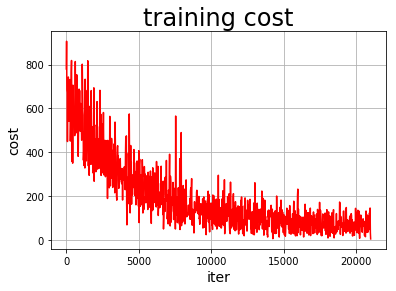

In [ ]:
EPOCH_NUM=50
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)

# **Step5.模型预测**

**（1）创建预测用的Executor**

In [ ]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**(2)可视化真实值与预测值方法定义**

In [ ]:
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='green',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results: (House Price)
0: 15.02
1: 14.99
2: 15.12
3: 16.44
4: 15.45
5: 15.79
6: 15.28
7: 15.19
8: 13.48
9: 15.23
10: 12.92
11: 14.30
12: 14.90
13: 14.56
14: 14.13
15: 15.40
16: 16.35
17: 16.32
18: 16.53
19: 15.13
20: 15.78
21: 14.59
22: 16.17
23: 15.53
24: 15.59
25: 14.99
26: 15.93
27: 15.73
28: 16.69
29: 15.92
30: 15.71
31: 15.18
32: 15.28
33: 14.32
34: 14.04
35: 15.81
36: 15.79
37: 16.23
38: 16.45
39: 16.25
40: 15.24
41: 14.86
42: 16.21
43: 16.47
44: 16.36
45: 16.07
46: 15.51
47: 16.46
48: 16.61
49: 16.77
50: 15.38
51: 15.69
52: 15.33
53: 15.58
54: 16.50
55: 16.94
56: 16.45
57: 16.96
58: 17.09
59: 17.33
60: 17.54
61: 17.51
62: 15.71
63: 16.24
64: 16.90
65: 17.48
66: 17.13
67: 17.40
68: 17.51
69: 17.84
70: 16.33
71: 15.86
72: 16.72
73: 15.53
74: 16.51
75: 17.01
76: 18.04
77: 18.23
78: 18.36
79: 18.45
80: 18.03
81: 18.26
82: 17.31
83: 17.96
84: 17.50
85: 16.75
86: 16.13
87: 17.53
88: 18.23
89: 21.15
90: 21.28
91: 21.15
92: 20.03
93: 20.76
94: 20.97
95: 20.52
96: 20.61
97: 21.70
9

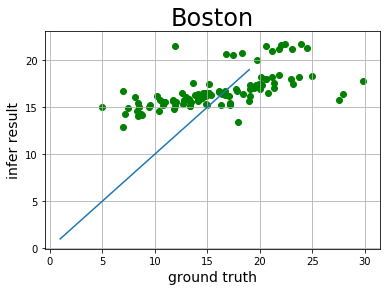

In [ ]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)

到这里你已经学会了PaddlePaddle的基本命令和第一个小例子！恭喜你已经入门啦~如果想学习更多内容欢迎查看AI Studio 上的更多内容，有精选项目，也有优质课程，加油哦！